# Linear Regression Model

This notebook builds and evaluates a **Linear Regression** model to predict `estimated_daily_searches` using weather and temporal features.

**Focus**: Interpretable baseline model

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import pickle
import os
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
# Load UberEats data
url = "https://raw.githubusercontent.com/cedricly-git/BADS_Capstone_repo/main/Data/ubereats+time_related_vars.csv"
uber = pd.read_csv(url)
uber['Day'] = pd.to_datetime(uber['Day'])

print("UberEats Data Shape:", uber.shape)

# Load weather data for top 10 most populated cities in Switzerland
cities = {
    "Zurich": {"lat": 47.3769, "lon": 8.5417, "pop": 436551},
    "Geneva": {"lat": 46.2044, "lon": 6.1432, "pop": 209061},
    "Basel": {"lat": 47.5596, "lon": 7.5886, "pop": 177571},
    "Lausanne": {"lat": 46.5197, "lon": 6.6323, "pop": 144873},
    "Bern": {"lat": 46.9481, "lon": 7.4474, "pop": 137995},
    "Winterthur": {"lat": 47.5056, "lon": 8.7247, "pop": 120376},
    "Lucerne": {"lat": 47.0502, "lon": 8.3064, "pop": 86234},
    "St. Gallen": {"lat": 47.4245, "lon": 9.3767, "pop": 78863},
    "Lugano": {"lat": 46.0101, "lon": 8.9600, "pop": 63629},
    "Biel": {"lat": 47.1404, "lon": 7.2471, "pop": 56896}
}

# Calculate population weights
total_pop = sum(city["pop"] for city in cities.values())
city_weights = {name: city["pop"] / total_pop for name, city in cities.items()}

start_date = "2023-11-13"
end_date = "2025-11-11"

weather_data = []
print(f"\nFetching weather data for {len(cities)} cities...")
for city, coords in cities.items():
    url1 = (
        f"https://archive-api.open-meteo.com/v1/archive?"
        f"latitude={coords['lat']}&longitude={coords['lon']}"
        f"&start_date={start_date}&end_date={end_date}"
        f"&daily=temperature_2m_max,temperature_2m_min,precipitation_sum&timezone=Europe/Zurich"
    )
    data = requests.get(url1).json()
    for i, date in enumerate(data['daily']['time']):
        weather_data.append({
            "Day": datetime.strptime(date, "%Y-%m-%d"),
            "City": city,
            "Temp_Max": data['daily']['temperature_2m_max'][i],
            "Temp_Min": data['daily']['temperature_2m_min'][i],
            "Precipitation": data['daily']['precipitation_sum'][i]
        })
    print(f"  ✓ {city}")

weather_df = pd.DataFrame(weather_data)

# Calculate population-weighted average weather
weather_df['pop_weight'] = weather_df['City'].map(city_weights)
weather_avg = weather_df.groupby('Day').apply(
    lambda x: pd.Series({
        'Temp_Max': (x['Temp_Max'] * x['pop_weight']).sum(),
        'Temp_Min': (x['Temp_Min'] * x['pop_weight']).sum(),
        'Precipitation': (x['Precipitation'] * x['pop_weight']).sum()
    })
).reset_index()

# Merge datasets
df = pd.merge(uber, weather_avg, on='Day', how='left')

# Add derived features
df["temp_range"] = df["Temp_Max"] - df["Temp_Min"]
df["dayofweek"] = df["Day"].dt.weekday
df["month_num"] = df["Day"].dt.month
df["year"] = df["Day"].dt.year

# Drop columns that shouldn't be used as features (they were used to create estimated_daily_searches)
columns_to_drop = ['weight', 'trend_value', 'total_uber', 'total_ubereats']
for col in columns_to_drop:
    if col in df.columns:
        df = df.drop(columns=[col])
        print(f"Dropped column: {col}")

print(f"\nMerged Dataset Shape: {df.shape}")
print(f"Date range: {df['Day'].min().date()} to {df['Day'].max().date()}")
print(f"Missing values: {df.isnull().sum().sum()}")


UberEats Data Shape: (728, 10)

Fetching weather data for 10 cities...
  ✓ Zurich
  ✓ Geneva
  ✓ Basel
  ✓ Lausanne
  ✓ Bern
  ✓ Winterthur
  ✓ Lucerne
  ✓ St. Gallen
  ✓ Lugano
  ✓ Biel
Dropped column: weight
Dropped column: trend_value
Dropped column: total_ubereats

Merged Dataset Shape: (728, 14)
Date range: 2023-11-13 to 2025-11-11
Missing values: 0


## 2. Advanced Feature Engineering


In [3]:
# Cyclical encoding for temporal features (better than linear encoding)
df['dayofweek_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
df['dayofweek_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)
df['month_sin'] = np.sin(2 * np.pi * df['month_num'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month_num'] / 12)

# Weather-derived features
df['temp_comfort'] = (df['Temp_Max'] + df['Temp_Min']) / 2  # Average temperature
df['precip_binary'] = (df['Precipitation'] > 0).astype(int)  # Rain/no rain
df['precip_heavy'] = (df['Precipitation'] > 10).astype(int)  # Heavy rain flag

# Lag features (previous day weather - may affect today's searches)
df['Temp_Max_lag1'] = df['Temp_Max'].shift(1)
df['Temp_Min_lag1'] = df['Temp_Min'].shift(1)
df['Precipitation_lag1'] = df['Precipitation'].shift(1)
df['estimated_daily_searches_lag1'] = df['estimated_daily_searches'].shift(1)

# Extended lag features (lag7 for weekly patterns - lag14 removed to preserve more data)
df['estimated_daily_searches_lag7'] = df['estimated_daily_searches'].shift(7)
df['Temp_Max_lag7'] = df['Temp_Max'].shift(7)
df['Temp_Min_lag7'] = df['Temp_Min'].shift(7)
df['Precipitation_lag7'] = df['Precipitation'].shift(7)

# Rolling averages (smooth out daily fluctuations)
df['Temp_Max_7d'] = df['Temp_Max'].rolling(window=7, center=True).mean()
df['Precipitation_7d'] = df['Precipitation'].rolling(window=7, center=True).mean()

# Polynomial features (capture non-linear temperature effects)
df['Temp_Max_squared'] = df['Temp_Max'] ** 2  # Optimal temperature range effect

# Interaction features (weather × temporal interactions)
# These capture how weather effects differ on weekends/holidays
df['Temp_Max_weekend'] = df['Temp_Max'] * df['is_weekend']
df['Precipitation_weekend'] = df['Precipitation'] * df['is_weekend']
df['temp_comfort_weekend'] = df['temp_comfort'] * df['is_weekend']

# Drop rows with NaN from lag/rolling features
df = df.dropna()

print(f"Dataset shape after feature engineering: {df.shape}")
print(f"\nNew features created:")
print("- Cyclical encoding: dayofweek_sin/cos, month_sin/cos")
print("- Weather derived: temp_comfort, precip_binary, precip_heavy")
print("- Lag features (lag1): Temp_Max_lag1, Temp_Min_lag1, Precipitation_lag1, estimated_daily_searches_lag1")
print("- Extended lag features (lag7): estimated_daily_searches, Temp_Max, Temp_Min, Precipitation")
print("- Rolling averages: Temp_Max_7d, Precipitation_7d")
print("- Polynomial features: Temp_Max_squared")
print("- Interaction features: Temp_Max_weekend, Precipitation_weekend, temp_comfort_weekend")


Dataset shape after feature engineering: (718, 35)

New features created:
- Cyclical encoding: dayofweek_sin/cos, month_sin/cos
- Weather derived: temp_comfort, precip_binary, precip_heavy
- Lag features (lag1): Temp_Max_lag1, Temp_Min_lag1, Precipitation_lag1, estimated_daily_searches_lag1
- Extended lag features (lag7): estimated_daily_searches, Temp_Max, Temp_Min, Precipitation
- Rolling averages: Temp_Max_7d, Precipitation_7d
- Polynomial features: Temp_Max_squared
- Interaction features: Temp_Max_weekend, Precipitation_weekend, temp_comfort_weekend


## 3. Train-Test Split (Time-Series Aware)


In [4]:
# Sort by date to ensure proper time-series split
df = df.sort_values('Day').reset_index(drop=True)

# Time-based split (last 20% for testing)
split_idx = int(len(df) * 0.8)
train_df = df.iloc[:split_idx].copy()
test_df = df.iloc[split_idx:].copy()

print(f"Training set: {len(train_df)} days ({train_df['Day'].min().date()} to {train_df['Day'].max().date()})")
print(f"Test set: {len(test_df)} days ({test_df['Day'].min().date()} to {test_df['Day'].max().date()})")

# Define target and features
target = 'estimated_daily_searches'

# Feature selection - interpretable features for linear models
feature_candidates = [
    # Temporal
    'is_weekend', 'is_holiday', 'dayofweek_sin', 'dayofweek_cos', 
    'month_sin', 'month_cos',
    # Weather
    'Temp_Max', 'Temp_Min', 'Precipitation', 'temp_range', 'temp_comfort',
    'precip_binary', 'precip_heavy',
    # Lag features (lag1)
    'Temp_Max_lag1', 'Temp_Min_lag1', 'Precipitation_lag1', 'estimated_daily_searches_lag1',
    # Extended lag features (lag7)
    'estimated_daily_searches_lag7',
    'Temp_Max_lag7', 'Temp_Min_lag7', 'Precipitation_lag7',
    # Rolling averages
    'Temp_Max_7d', 'Precipitation_7d',
    # Polynomial features
    'Temp_Max_squared',
    # Interaction features
    'Temp_Max_weekend', 'Precipitation_weekend', 'temp_comfort_weekend'
]

# Check which features exist
available_features = [f for f in feature_candidates if f in df.columns]
print(f"\nAvailable features: {len(available_features)}")
print(available_features)

X_train = train_df[available_features]
y_train = train_df[target]
X_test = test_df[available_features]
y_test = test_df[target]

print(f"\nFeature matrix shape - Train: {X_train.shape}, Test: {X_test.shape}")

# Optional: Feature scaling (helps with regularization, but makes coefficients less interpretable)
# For interpretability, we'll skip scaling, but models with regularization can benefit
# Uncomment below if you want to use scaling:
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)
# X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
# X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)


Training set: 574 days (2023-11-20 to 2025-06-17)
Test set: 144 days (2025-06-18 to 2025-11-08)

Available features: 27
['is_weekend', 'is_holiday', 'dayofweek_sin', 'dayofweek_cos', 'month_sin', 'month_cos', 'Temp_Max', 'Temp_Min', 'Precipitation', 'temp_range', 'temp_comfort', 'precip_binary', 'precip_heavy', 'Temp_Max_lag1', 'Temp_Min_lag1', 'Precipitation_lag1', 'estimated_daily_searches_lag1', 'estimated_daily_searches_lag7', 'Temp_Max_lag7', 'Temp_Min_lag7', 'Precipitation_lag7', 'Temp_Max_7d', 'Precipitation_7d', 'Temp_Max_squared', 'Temp_Max_weekend', 'Precipitation_weekend', 'temp_comfort_weekend']

Feature matrix shape - Train: (574, 27), Test: (144, 27)


## 4. Linear Regression Model

In [5]:
# Evaluation function
def evaluate_model(y_true, y_pred, model_name):
    """Calculate and display multiple evaluation metrics"""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n{model_name} Performance:")
    print("=" * 50)
    print(f"RMSE:  {rmse:.2f}")
    print(f"MAE:   {mae:.2f}")
    print(f"MAPE:  {mape:.2f}%")
    print(f"R²:    {r2:.4f}")
    
    return {'RMSE': rmse, 'MAE': mae, 'MAPE': mape, 'R²': r2}

# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
results_lr = evaluate_model(y_test, y_pred_lr, "Linear Regression")

# Display top coefficients
coef_df = pd.DataFrame({
    'feature': X_train.columns,
    'coefficient': lr.coef_
}).sort_values('coefficient', key=abs, ascending=False)

print("\nTop 10 Features by Absolute Coefficient:")
print(coef_df.head(10))


Linear Regression Performance:
RMSE:  691.85
MAE:   532.14
MAPE:  19.99%
R²:    0.3516

Top 10 Features by Absolute Coefficient:
                 feature  coefficient
0             is_weekend   446.077226
1             is_holiday   396.979603
3          dayofweek_cos  -270.830174
4              month_sin  -268.664755
5              month_cos  -217.396109
2          dayofweek_sin    53.557473
22      Precipitation_7d   -26.733747
21           Temp_Max_7d   -25.498288
11         precip_binary    17.167312
26  temp_comfort_weekend    15.702816


## 5. Save Model and Results

In [6]:
# Save model, predictions, and results for comparison notebook
os.makedirs('models', exist_ok=True)
os.makedirs('results', exist_ok=True)

# Save model
with open('models/linear_regression.pkl', 'wb') as f:
    pickle.dump(lr, f)

# Save predictions and results
linear_results = {
    'model_name': 'Linear Regression',
    'predictions': y_pred_lr.tolist(),
    'metrics': results_lr,
    'test_dates': test_df['Day'].dt.strftime('%Y-%m-%d').tolist(),
    'y_test': y_test.tolist()
}

with open('results/linear_regression_results.pkl', 'wb') as f:
    pickle.dump(linear_results, f)

print("Model and results saved successfully!")
print(f"Model saved to: models/linear_regression.pkl")
print(f"Results saved to: results/linear_regression_results.pkl")

Model and results saved successfully!
Model saved to: models/linear_regression.pkl
Results saved to: results/linear_regression_results.pkl


## 6. Key Visualization

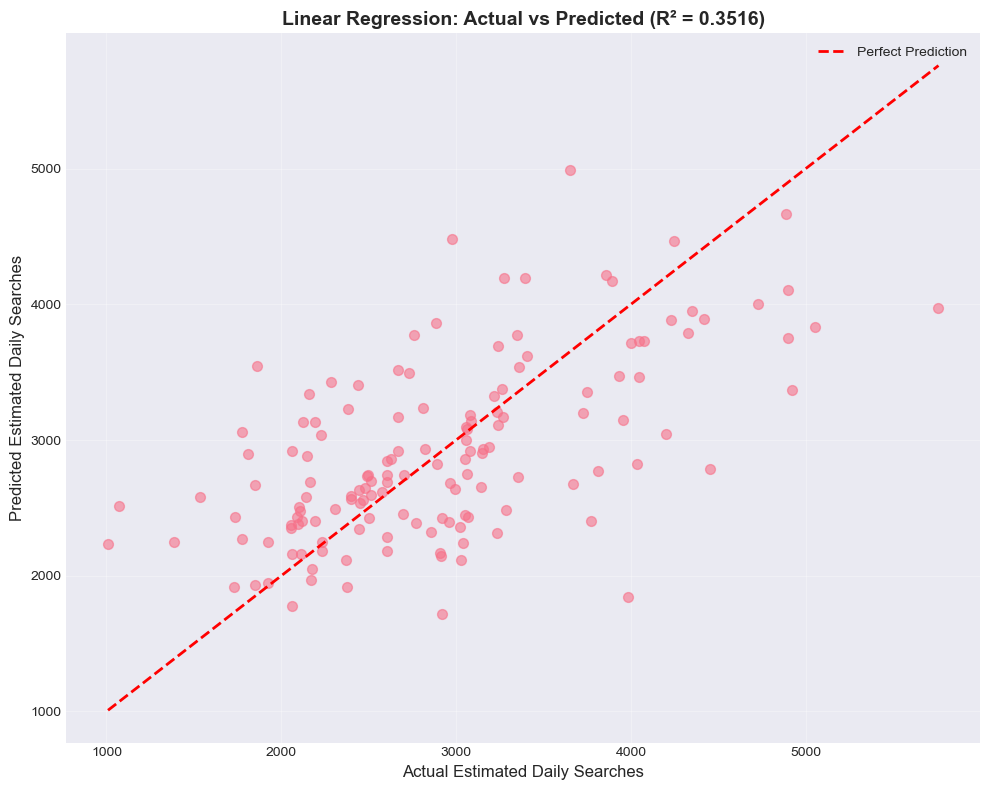

In [7]:
# Scatter plot: Actual vs Predicted
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred_lr, alpha=0.6, s=50)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2, label='Perfect Prediction')
plt.xlabel('Actual Estimated Daily Searches', fontsize=12)
plt.ylabel('Predicted Estimated Daily Searches', fontsize=12)
plt.title(f'Linear Regression: Actual vs Predicted (R² = {results_lr["R²"]:.4f})', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()